<a href="https://colab.research.google.com/github/fojeda/workshop-kbc-25/blob/workshop_handson/06%20-%20Sensitivity%20Analysis%20%26%20Advanced_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dowhy==0.12 econml==0.15 networkx==3.3 "numpy<2.0" ananke-causal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 530.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.

In [1]:
from ananke.graphs import ADMG
from ananke.identification import OneLineID
from ananke.estimation import CausalEffect
from ananke.datasets import load_afixable_data
from ananke.estimation import AutomatedIF
import numpy as np

import re
import dowhy
from dowhy import CausalModel
import dowhy.datasets
from dowhy.utils.regression import create_polynomial_function
from sklearn.ensemble import GradientBoostingRegressor

# Sensitivity Analysis and Advanced Identification

## Sensitivity Analysis with DoWhy

In [2]:
# Generate the data
data = dowhy.datasets.partially_linear_dataset(
    beta=10,
    num_common_causes=7,
    num_unobserved_common_causes=1,
    strength_unobserved_confounding=10,
    num_samples=1000,
    num_treatments=1,
    stddev_treatment_noise=10,
    stddev_outcome_noise=5
)

In [3]:
# True effect
data["ate"]

9.466985777632301

In [4]:
# Drop W0 -> unobserved confounder
dropped_cols = ["W0"]
user_data = data["df"].drop(dropped_cols, axis = 1)

user_graph = data["gml_graph"]
for col in dropped_cols:
    user_graph = user_graph.replace('node[ id "{0}" label "{0}"]'.format(col), '')
    user_graph = re.sub('edge\[ source "{}" target "[vy][0]*"\]'.format(col), "", user_graph)

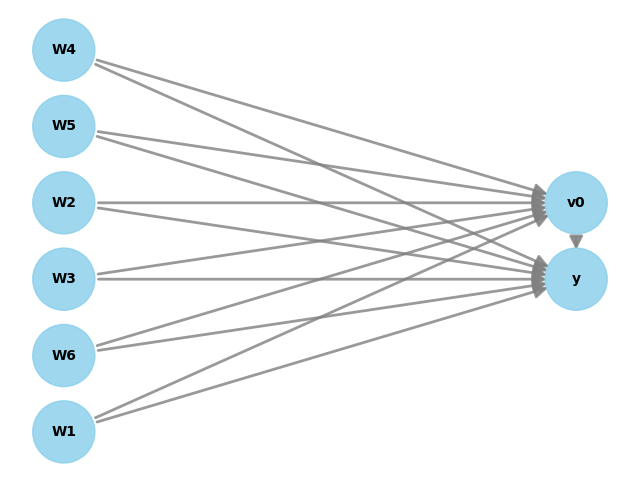

In [5]:
# Define the causal model
model = CausalModel(
    data=user_data,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=user_graph,
    test_significance=None,
)

model.view_model()

In [6]:
# Get the estimand
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W1,W6,W3,W2,W5,W4])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W6,W3,W2,W5,W4,U) = P(y|v0,W1,W6,W3,W2,W5,W4)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
# Estimate the effect
linear_dml_estimate = model.estimate_effect(
    estimand,
    method_name="backdoor.econml.dml.dml.LinearDML",
    method_params={
        'init_params': {'model_y':GradientBoostingRegressor(),
                        'model_t': GradientBoostingRegressor(),
                        'linear_first_stages': False
                        },
        'fit_params': {'cache_values': True,}
        })

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


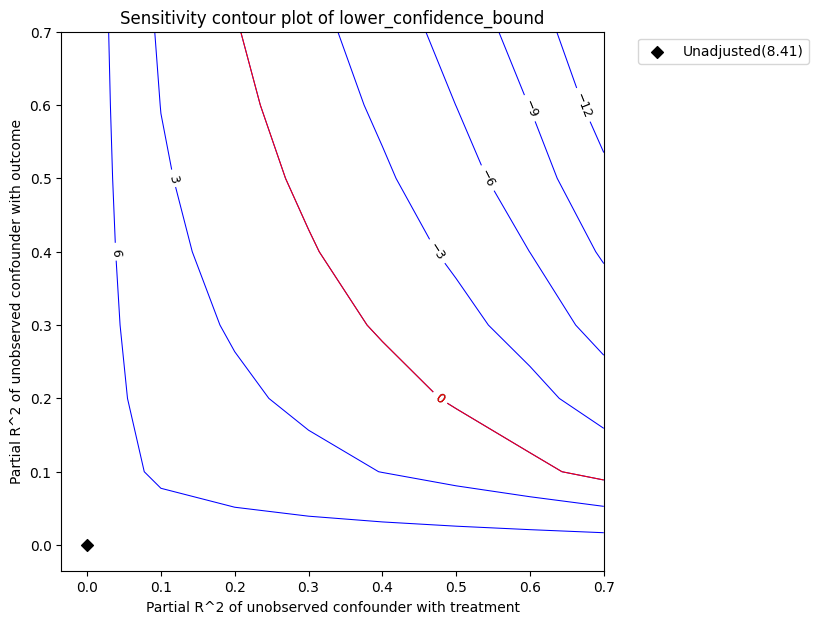

Sensitivity Analysis to Unobserved Confounding using partial R^2 parameterization

Original Effect Estimate : 8.413179855219157
Robustness Value : 0.39

Robustness Value (alpha=0.05) : 0.35000000000000003

Interpretation of results :
Any confounder explaining less than 39.0% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 35.0% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'




In [8]:
# Sensitivity refuter
refutation_sensitivity = model.refute_estimate(
    estimand, linear_dml_estimate,
    method_name = "add_unobserved_common_cause",
    simulation_method = "non-parametric-partial-R2",
    partial_r2_confounder_treatment = np.arange(0, 0.8, 0.1),
    partial_r2_confounder_outcome = np.arange(0, 0.8, 0.1)
    )
print(refutation_sensitivity)

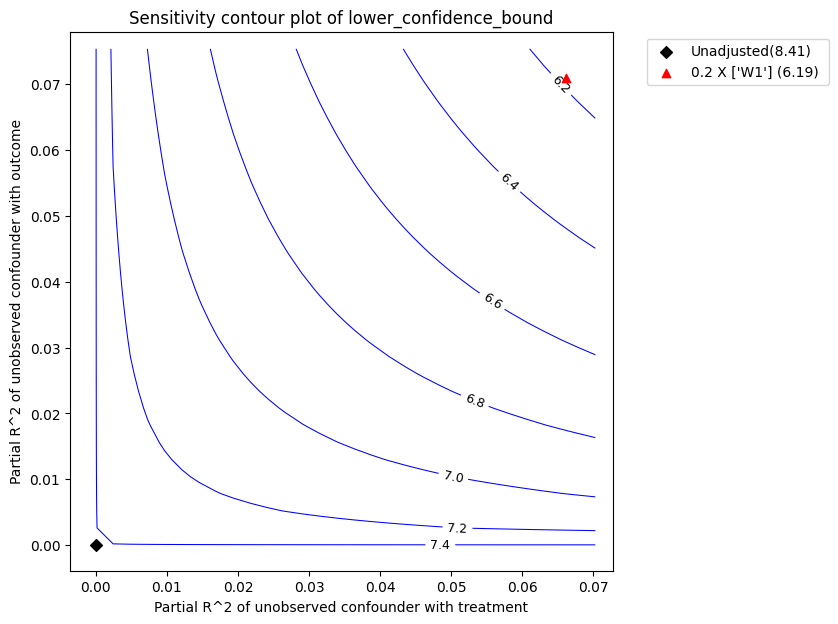

In [9]:
refute_bm = model.refute_estimate(
    estimand, linear_dml_estimate,
    method_name = "add_unobserved_common_cause",
    simulation_method = "non-parametric-partial-R2",
    benchmark_common_causes = ["W1"],
    effect_fraction_on_treatment = 0.2,
    effect_fraction_on_outcome = 0.2
    )

## Advanced Identification with Ananke

In [ ]:
# Read the data
data = load_afixable_data()

In [ ]:
nodes = ['Income', 'Insurance', 'ViralLoad', 'Education', 'T', 'Toxicity', 'CD4']

di_edges = [('ViralLoad', 'Income'), ('ViralLoad', 'T'), ('ViralLoad', 'Toxicity'),
            ('Education', 'Income'), ('Education', 'T'), ('Education', 'Toxicity'),
            ('Income', 'Insurance'), ('Insurance', 'T'), ('T', 'Toxicity'), ('Toxicity', 'CD4'), ('T', 'CD4')]

bi_edges = [('Income', 'T'), ('Insurance', 'ViralLoad'), ('Education', 'CD4')]

G = ADMG(nodes, di_edges, bi_edges)

G.draw(direction="LR")

In [ ]:
# Check if the effect is identifiable
effect_id = OneLineID(graph=G, treatments=['T'], outcomes=['CD4'])
effect_id.id()

In [ ]:
# Instantiate the causal effect object
model = CausalEffect(
    graph=G,
    treatment='T',
    outcome='CD4'
    )

In [ ]:
# Compute effects using different estimators
ate_ipw = ace_obj.compute_effect(data, "ipw")
ate_gformula = ace_obj.compute_effect(data, "gformula")
ate_aipw = ace_obj.compute_effect(data, "aipw")
ate_eff = ace_obj.compute_effect(data, "eff-aipw")

print("ATE using IPW = ", ate_ipw)
print("ATE using g-formula = ", ate_gformula)
print("ATE using AIPW = ", ate_aipw)
print("ATE using efficient AIPW = ", ate_eff)